In [1]:
!pip install pyspark

In [2]:
# 1. Setup: imports and SparkSession
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnan, sum as spark_sum, round as spark_round, avg
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go

# Start SparkSession
spark = SparkSession.builder \
    .appName("AirlineDelaysAnalysis") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print('✅ Spark session created')

✅ Spark session created


In [4]:
# 2. Load dataset
csv_path = "airline_delay.csv"
df = spark.read.csv(csv_path, header=True, inferSchema=False)

print('📊 Rows:', df.count())
df.printSchema()
df.show(5, truncate=False)

📊 Rows: 3351
root
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- carrier: string (nullable = true)
 |-- carrier_name: string (nullable = true)
 |-- airport: string (nullable = true)
 |-- airport_name: string (nullable = true)
 |-- arr_flights: string (nullable = true)
 |-- arr_del15: string (nullable = true)
 |-- carrier_ct: string (nullable = true)
 |-- weather_ct: string (nullable = true)
 |-- nas_ct: string (nullable = true)
 |-- security_ct: string (nullable = true)
 |-- late_aircraft_ct: string (nullable = true)
 |-- arr_cancelled: string (nullable = true)
 |-- arr_diverted: string (nullable = true)
 |-- arr_delay: string (nullable = true)
 |-- carrier_delay: string (nullable = true)
 |-- weather_delay: string (nullable = true)
 |-- nas_delay: string (nullable = true)
 |-- security_delay: string (nullable = true)
 |-- late_aircraft_delay: string (nullable = true)

+----+-----+-------+-----------------+-------+-----------------------------------------

In [5]:
# 3. Data Cleaning & Feature Engineering
numeric_cols = [
    'arr_flights','arr_del15','arr_cancelled','arr_diverted','arr_delay',
    'carrier_ct','weather_ct','nas_ct','security_ct','late_aircraft_ct',
    'carrier_delay','weather_delay','nas_delay','security_delay','late_aircraft_delay'
]

# Handle NA / non-numeric
for c in numeric_cols:
    if c in df.columns:
        df = df.withColumn(c, when(col(c).isin("NA","NaN","","null","None","."), None).otherwise(col(c)))
        df = df.withColumn(c, col(c).cast("double"))

# Create new features
df = df.withColumn('pct_delayed', when(col('arr_flights') > 0, col('arr_del15')/col('arr_flights')).otherwise(0))
df = df.withColumn('avg_delay_per_arrival', when(col('arr_flights') > 0, col('arr_delay')/col('arr_flights')).otherwise(0))

# Missing values check
missing_df = df.select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns])
missing_df.show(truncate=False)


+----+-----+-------+------------+-------+------------+-----------+---------+----------+----------+------+-----------+----------------+-------------+------------+---------+-------------+-------------+---------+--------------+-------------------+-----------+---------------------+
|year|month|carrier|carrier_name|airport|airport_name|arr_flights|arr_del15|carrier_ct|weather_ct|nas_ct|security_ct|late_aircraft_ct|arr_cancelled|arr_diverted|arr_delay|carrier_delay|weather_delay|nas_delay|security_delay|late_aircraft_delay|pct_delayed|avg_delay_per_arrival|
+----+-----+-------+------------+-------+------------+-----------+---------+----------+----------+------+-----------+----------------+-------------+------------+---------+-------------+-------------+---------+--------------+-------------------+-----------+---------------------+
|0   |0    |0      |0           |0      |0           |8          |8        |8         |8         |8     |8          |8               |8            |8           |8 

In [8]:
# 4. Overall Aggregations
overall = df.agg(
    spark_sum('arr_flights').alias('total_flights'),
    spark_sum('arr_del15').alias('total_delayed'),
    spark_sum('arr_cancelled').alias('total_cancelled'),
    avg('avg_delay_per_arrival').alias('avg_delay_per_flight')
)
overall.show()



+-------------+-------------+---------------+--------------------+
|total_flights|total_delayed|total_cancelled|avg_delay_per_flight|
+-------------+-------------+---------------+--------------------+
|     997120.0|     170477.0|         9643.0|  10.788179352089402|
+-------------+-------------+---------------+--------------------+



In [7]:
overall_pct = overall.withColumn('pct_delayed', spark_round(col('total_delayed')/col('total_flights')*100,2))
overall_pct.show()

+-------------+-------------+---------------+--------------------+-----------+
|total_flights|total_delayed|total_cancelled|avg_delay_per_flight|pct_delayed|
+-------------+-------------+---------------+--------------------+-----------+
|     997120.0|     170477.0|         9643.0|  10.788179352089402|       17.1|
+-------------+-------------+---------------+--------------------+-----------+



In [9]:
# 5. Top carriers by delays
top_carriers = df.groupBy('carrier','carrier_name') \
    .agg(
        spark_sum('arr_flights').alias('flights'),
        spark_sum('arr_del15').alias('delayed'),
        spark_round((spark_sum('arr_del15')/spark_sum('arr_flights'))*100,2).alias('pct_delayed'),
        spark_round(spark_sum('arr_delay')/spark_sum('arr_flights'),2).alias('avg_delay_per_flight')
    ) \
    .orderBy(col('pct_delayed').desc())


In [10]:
top_carriers.show(10, truncate=False)
top_carriers_pd = top_carriers.limit(10).toPandas()


+-------+-----------------------+--------+-------+-----------+--------------------+
|carrier|carrier_name           |flights |delayed|pct_delayed|avg_delay_per_flight|
+-------+-----------------------+--------+-------+-----------+--------------------+
|B6     |JetBlue Airways        |36181.0 |10363.0|28.64      |23.9                |
|EV     |ExpressJet Airlines LLC|11203.0 |2694.0 |24.05      |22.69               |
|YV     |Mesa Airlines Inc.     |30502.0 |6359.0 |20.85      |17.4                |
|G4     |Allegiant Air          |16749.0 |3480.0 |20.78      |14.37               |
|AS     |Alaska Airlines Inc.   |33001.0 |6294.0 |19.07      |10.64               |
|F9     |Frontier Airlines Inc. |19587.0 |3654.0 |18.66      |11.88               |
|OH     |PSA Airlines Inc.      |38567.0 |7162.0 |18.57      |12.44               |
|MQ     |Envoy Air              |43914.0 |8070.0 |18.38      |11.5                |
|UA     |United Air Lines Inc.  |77183.0 |13498.0|17.49      |11.71         

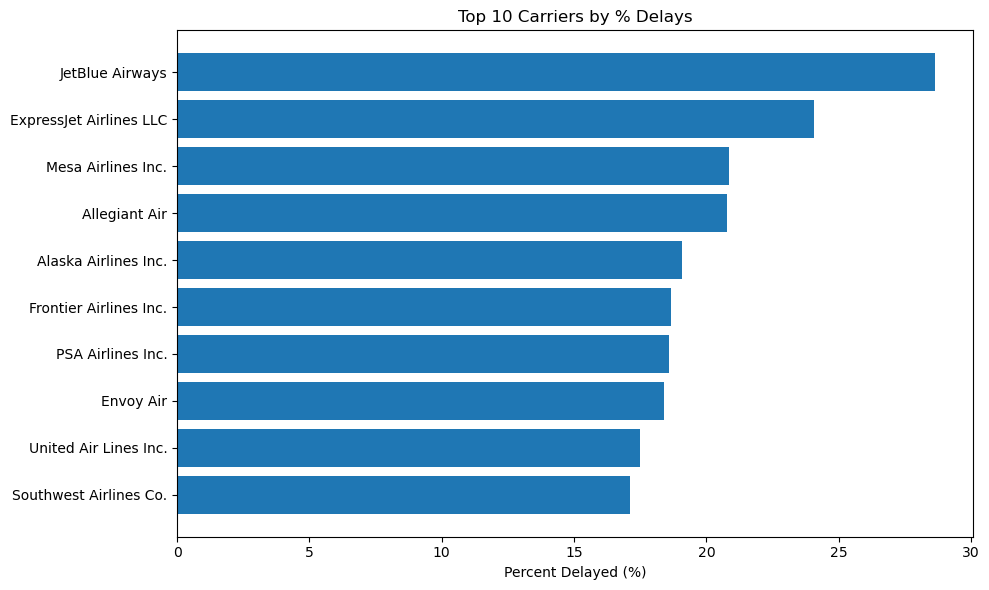

In [11]:
# Plot
plt.figure(figsize=(10,6))
plt.barh(top_carriers_pd['carrier_name'][::-1], top_carriers_pd['pct_delayed'][::-1])
plt.xlabel('Percent Delayed (%)')
plt.title('Top 10 Carriers by % Delays')
plt.tight_layout()
plt.show()



In [12]:
 #6. Top airports with delays
top_airports = df.groupBy('airport','airport_name') \
    .agg(
        spark_sum('arr_flights').alias('flights'),
        spark_sum('arr_del15').alias('delayed'),
        spark_round((spark_sum('arr_del15')/spark_sum('arr_flights'))*100,2).alias('pct_delayed')
    ) \
    .orderBy(col('delayed').desc())

In [13]:
top_airports.show(10, truncate=False)
top_airports_pd = top_airports.limit(10).toPandas()


+-------+------------------------------------------------------+-------+-------+-----------+
|airport|airport_name                                          |flights|delayed|pct_delayed|
+-------+------------------------------------------------------+-------+-------+-----------+
|DFW    |Dallas/Fort Worth, TX: Dallas/Fort Worth International|45256.0|8448.0 |18.67      |
|ORD    |Chicago, IL: Chicago O'Hare International             |40016.0|6610.0 |16.52      |
|DEN    |Denver, CO: Denver International                      |39505.0|6569.0 |16.63      |
|ATL    |Atlanta, GA: Hartsfield-Jackson Atlanta International |55438.0|6554.0 |11.82      |
|LAX    |Los Angeles, CA: Los Angeles International            |28751.0|5372.0 |18.68      |
|SFO    |San Francisco, CA: San Francisco International        |20230.0|5170.0 |25.56      |
|EWR    |Newark, NJ: Newark Liberty International              |16775.0|4646.0 |27.7       |
|CLT    |Charlotte, NC: Charlotte Douglas International        |33316.

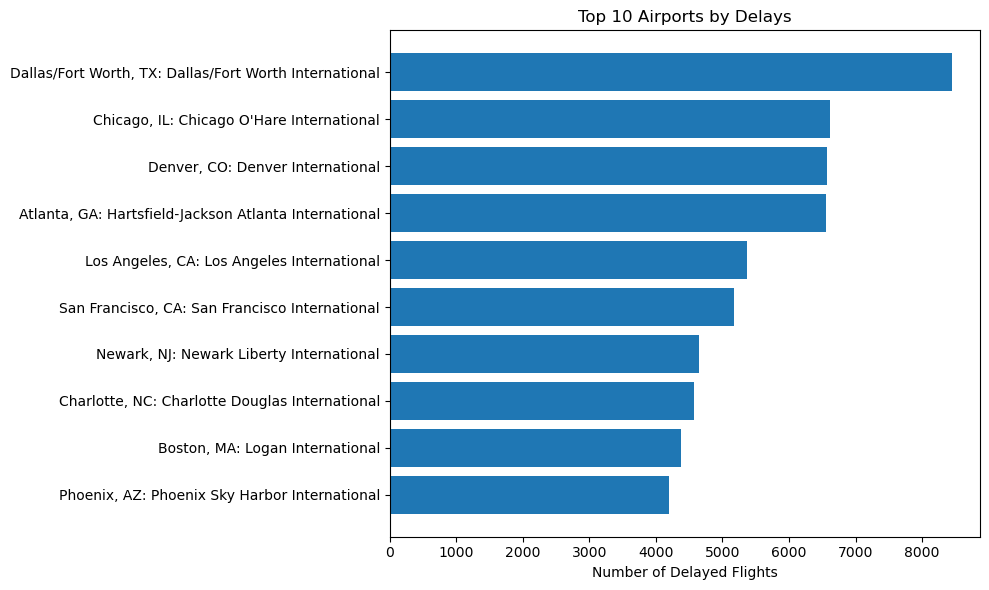

In [14]:
plt.figure(figsize=(10,6))
plt.barh(top_airports_pd['airport_name'][::-1], top_airports_pd['delayed'][::-1])
plt.xlabel('Number of Delayed Flights')
plt.title('Top 10 Airports by Delays')
plt.tight_layout()
plt.show()

In [15]:
# 7. Delay causes breakdown
cause_cols = ['carrier_delay','weather_delay','nas_delay','security_delay','late_aircraft_delay']
cause_exprs = [spark_sum(c).alias(c) for c in cause_cols]
causes_total = df.agg(*cause_exprs)
causes_total.show()

+-------------+-------------+---------+--------------+-------------------+
|carrier_delay|weather_delay|nas_delay|security_delay|late_aircraft_delay|
+-------------+-------------+---------+--------------+-------------------+
|    3826943.0|     593688.0|2505844.0|       18055.0|          4200591.0|
+-------------+-------------+---------+--------------+-------------------+



In [16]:
causes_pd = causes_total.toPandas().T.reset_index()
causes_pd.columns = ['cause','minutes']
causes_pd = causes_pd.sort_values('minutes', ascending=False)

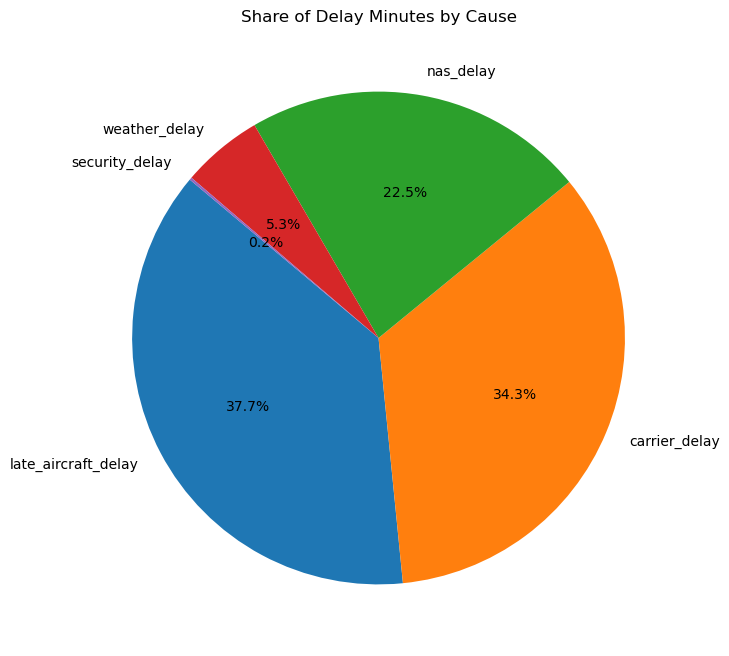

In [17]:
plt.figure(figsize=(8,8))
plt.pie(causes_pd['minutes'], labels=causes_pd['cause'], autopct='%1.1f%%', startangle=140)
plt.title('Share of Delay Minutes by Cause')
plt.show()

In [18]:
# 8. Monthly delay trends
monthly = df.groupBy('year','month') \
    .agg(
        spark_sum('arr_flights').alias('flights'),
        spark_sum('arr_del15').alias('delayed'),
        spark_sum('arr_delay').alias('delay_minutes')
    ) \
    .withColumn('pct_delayed', (col('delayed')/col('flights'))*100) \
    .orderBy('year','month')

In [19]:
monthly.show(20, truncate=False)

monthly_pd = monthly.toPandas().sort_values(['year','month'])
monthly_pd['year_month'] = monthly_pd['year'].astype(str) + '-' + monthly_pd['month'].astype(str).str.zfill(2)


+----+-----+--------+--------+-------------+------------------+
|year|month|flights |delayed |delay_minutes|pct_delayed       |
+----+-----+--------+--------+-------------+------------------+
|2019|12   |625763.0|126945.0|8584420.0    |20.28643432098095 |
|2020|12   |371357.0|43532.0 |2560701.0    |11.722412664901968|
+----+-----+--------+--------+-------------+------------------+



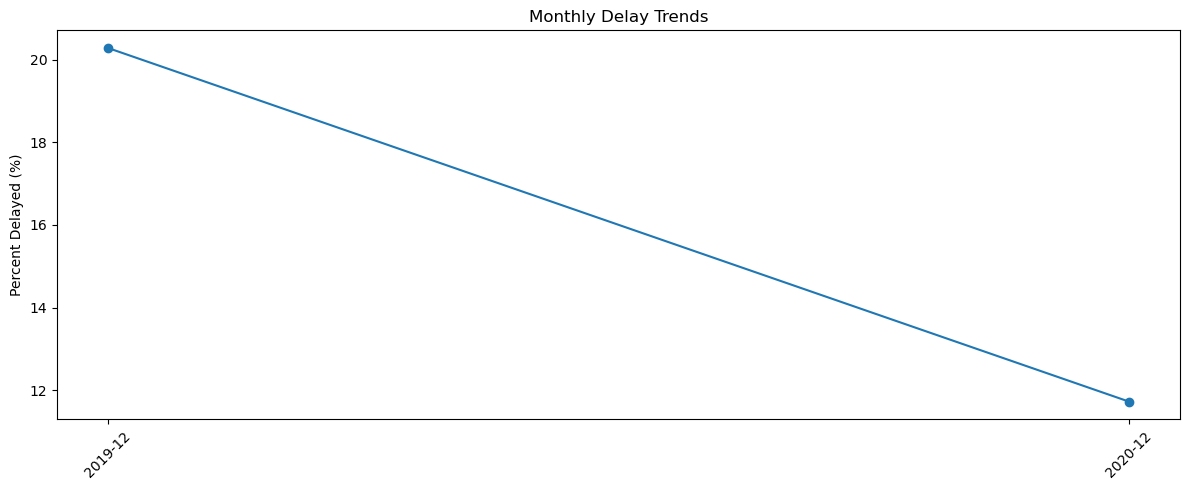

In [20]:
# Line chart for delay %
plt.figure(figsize=(12,5))
plt.plot(monthly_pd['year_month'], monthly_pd['pct_delayed'], marker='o')
plt.xticks(monthly_pd['year_month'][::max(1, len(monthly_pd)//20)], rotation=45)
plt.ylabel('Percent Delayed (%)')
plt.title('Monthly Delay Trends')
plt.tight_layout()
plt.show()

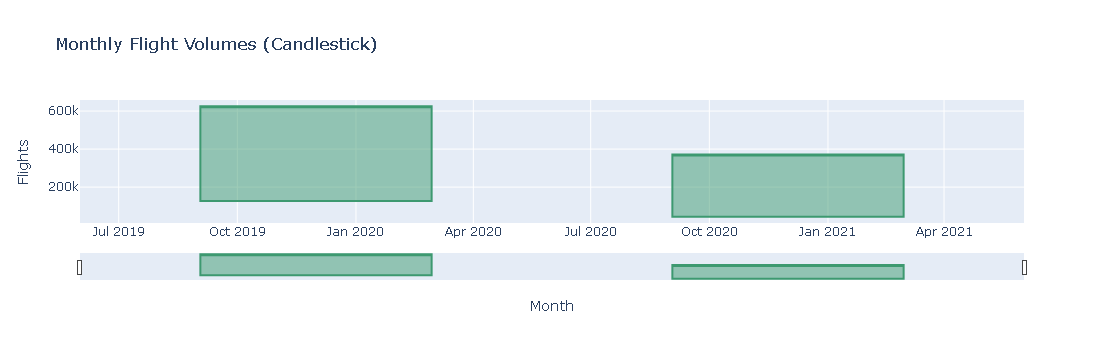

✅ Analysis completed


In [21]:
# 9. Candlestick Chart for Flight Volumes vs Delays
fig = go.Figure(data=[go.Candlestick(
    x=monthly_pd['year_month'],
    open=monthly_pd['delayed'],   # delayed as "open"
    high=monthly_pd['flights'],   # flights as "high"
    low=monthly_pd['delayed'],    # delayed as "low"
    close=monthly_pd['flights']   # flights as "close"
)])
fig.update_layout(title="Monthly Flight Volumes (Candlestick)", 
                  xaxis_title="Month", yaxis_title="Flights")
fig.show()

print("✅ Analysis completed")

In [22]:
# 10. Top 10 Busiest Airports (by flights)
busiest_airports = df.groupBy('airport','airport_name') \
    .agg(spark_sum('arr_flights').alias('flights')) \
    .orderBy(col('flights').desc())

In [23]:
busiest_airports.show(10, truncate=False)
busiest_airports_pd = busiest_airports.limit(10).toPandas()

+-------+------------------------------------------------------+-------+
|airport|airport_name                                          |flights|
+-------+------------------------------------------------------+-------+
|ATL    |Atlanta, GA: Hartsfield-Jackson Atlanta International |55438.0|
|DFW    |Dallas/Fort Worth, TX: Dallas/Fort Worth International|45256.0|
|ORD    |Chicago, IL: Chicago O'Hare International             |40016.0|
|DEN    |Denver, CO: Denver International                      |39505.0|
|CLT    |Charlotte, NC: Charlotte Douglas International        |33316.0|
|LAX    |Los Angeles, CA: Los Angeles International            |28751.0|
|PHX    |Phoenix, AZ: Phoenix Sky Harbor International         |25708.0|
|DTW    |Detroit, MI: Detroit Metro Wayne County               |23096.0|
|IAH    |Houston, TX: George Bush Intercontinental/Houston     |22871.0|
|LAS    |Las Vegas, NV: McCarran International                 |21750.0|
+-------+------------------------------------------

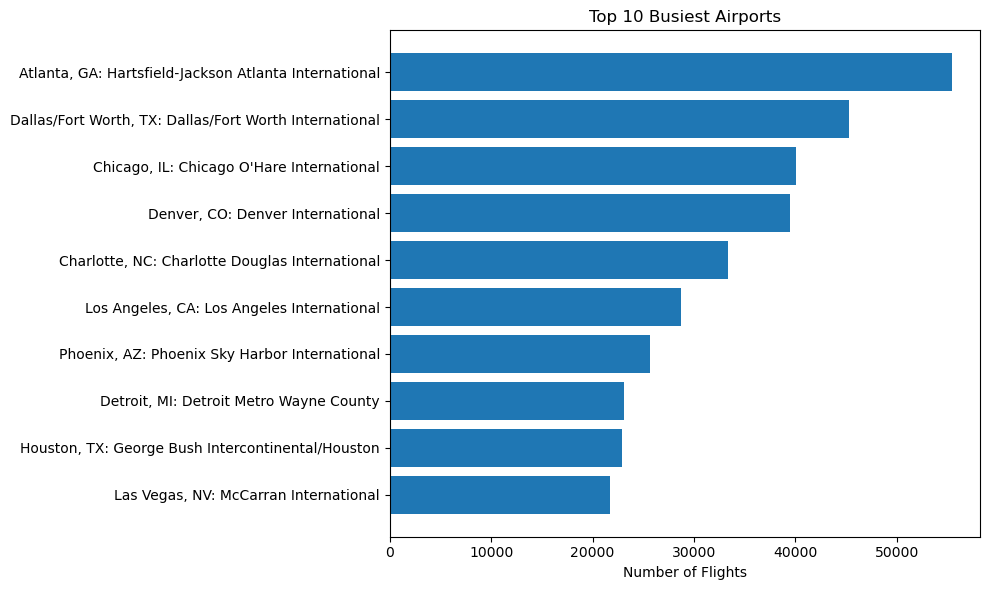

In [24]:
plt.figure(figsize=(10,6))
plt.barh(busiest_airports_pd['airport_name'][::-1], busiest_airports_pd['flights'][::-1])
plt.xlabel('Number of Flights')
plt.title('Top 10 Busiest Airports')
plt.tight_layout()
plt.show()

In [25]:
# 11. Most Common Delay Reasons (by count of delay minutes)
delay_reasons = df.select(*cause_cols)
delay_reasons_total = delay_reasons.agg(*[spark_sum(c).alias(c) for c in cause_cols])
delay_reasons_pd = delay_reasons_total.toPandas().T.reset_index()
delay_reasons_pd.columns = ['Reason','Minutes']
delay_reasons_pd = delay_reasons_pd.sort_values('Minutes', ascending=False)

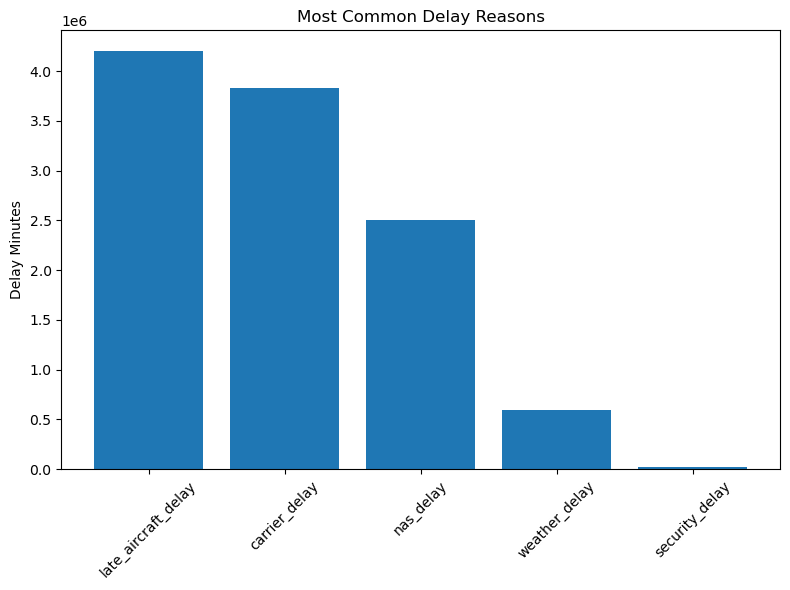

In [26]:

plt.figure(figsize=(8,6))
plt.bar(delay_reasons_pd['Reason'], delay_reasons_pd['Minutes'])
plt.xticks(rotation=45)
plt.title('Most Common Delay Reasons')
plt.ylabel('Delay Minutes')
plt.tight_layout()
plt.show()

In [27]:
# 12. Average Delay by Airline
avg_delay_airline = df.groupBy('carrier','carrier_name') \
    .agg(spark_round(avg('avg_delay_per_arrival'),2).alias('avg_delay')) \
    .orderBy(col('avg_delay').desc())

In [28]:
avg_delay_airline.show(10, truncate=False)
avg_delay_airline_pd = avg_delay_airline.limit(10).toPandas()

+-------+-----------------------+---------+
|carrier|carrier_name           |avg_delay|
+-------+-----------------------+---------+
|B6     |JetBlue Airways        |20.38    |
|EV     |ExpressJet Airlines LLC|18.37    |
|YV     |Mesa Airlines Inc.     |16.28    |
|OO     |SkyWest Airlines Inc.  |13.19    |
|G4     |Allegiant Air          |11.17    |
|OH     |PSA Airlines Inc.      |10.33    |
|UA     |United Air Lines Inc.  |10.23    |
|MQ     |Envoy Air              |9.55     |
|NK     |Spirit Air Lines       |9.21     |
|F9     |Frontier Airlines Inc. |9.1      |
+-------+-----------------------+---------+
only showing top 10 rows


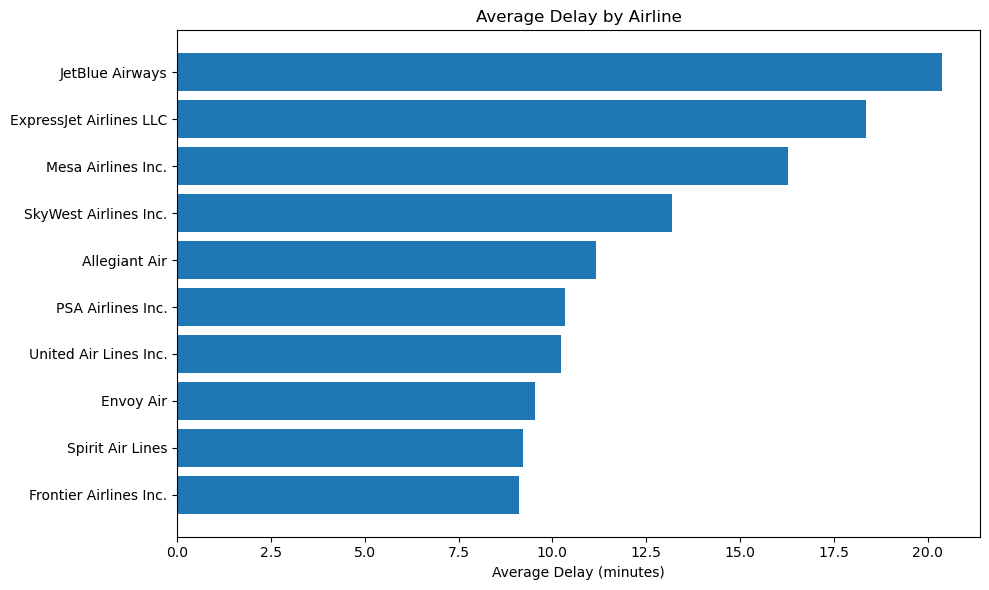

In [29]:
plt.figure(figsize=(10,6))
plt.barh(avg_delay_airline_pd['carrier_name'][::-1], avg_delay_airline_pd['avg_delay'][::-1])
plt.xlabel('Average Delay (minutes)')
plt.title('Average Delay by Airline')
plt.tight_layout()
plt.show()

In [30]:
# 13. Cancellation Rate by Airline
cancel_rate = df.groupBy('carrier','carrier_name') \
    .agg(
        spark_sum('arr_cancelled').alias('cancelled'),
        spark_sum('arr_flights').alias('flights')
    ) \
    .withColumn('cancel_rate', spark_round((col('cancelled')/col('flights'))*100,2)) \
    .orderBy(col('cancel_rate').desc())

In [31]:
cancel_rate.show(10, truncate=False)
cancel_rate_pd = cancel_rate.limit(10).toPandas()

+-------+-----------------------+---------+--------+-----------+
|carrier|carrier_name           |cancelled|flights |cancel_rate|
+-------+-----------------------+---------+--------+-----------+
|EV     |ExpressJet Airlines LLC|233.0    |11203.0 |2.08       |
|YX     |Republic Airline       |869.0    |50134.0 |1.73       |
|OO     |SkyWest Airlines Inc.  |2070.0   |126678.0|1.63       |
|YV     |Mesa Airlines Inc.     |486.0    |30502.0 |1.59       |
|G4     |Allegiant Air          |222.0    |16749.0 |1.33       |
|MQ     |Envoy Air              |561.0    |43914.0 |1.28       |
|AS     |Alaska Airlines Inc.   |405.0    |33001.0 |1.23       |
|WN     |Southwest Airlines Co. |1829.0   |178784.0|1.02       |
|9E     |Endeavor Air Inc.      |412.0    |45375.0 |0.91       |
|F9     |Frontier Airlines Inc. |175.0    |19587.0 |0.89       |
+-------+-----------------------+---------+--------+-----------+
only showing top 10 rows


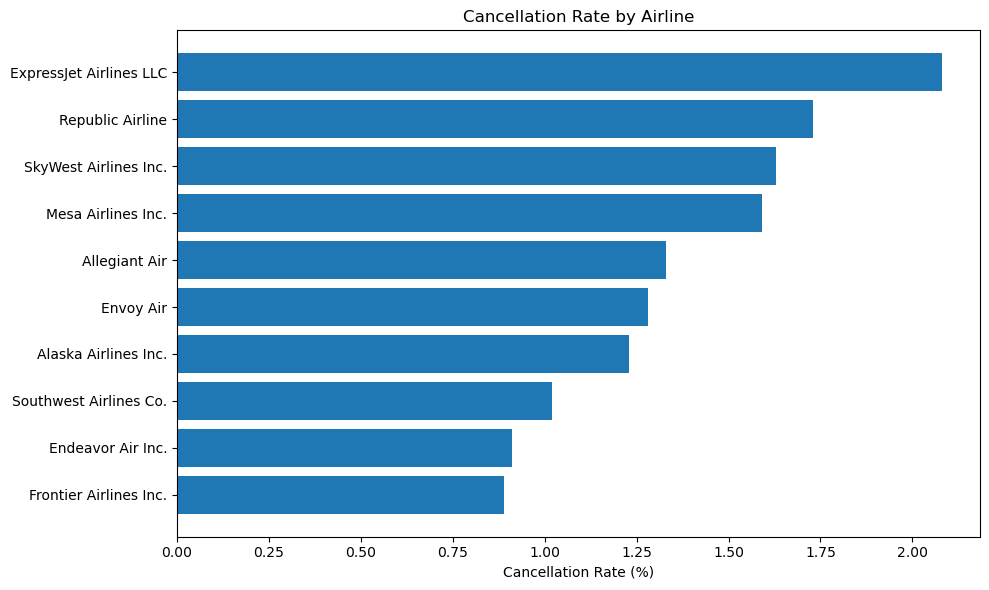

In [32]:
plt.figure(figsize=(10,6))
plt.barh(cancel_rate_pd['carrier_name'][::-1], cancel_rate_pd['cancel_rate'][::-1])
plt.xlabel('Cancellation Rate (%)')
plt.title('Cancellation Rate by Airline')
plt.tight_layout()
plt.show()

In [33]:
# 14. Delay Probability (delayed flights / total flights)
delay_prob = df.groupBy('carrier','carrier_name') \
    .agg(
        spark_sum('arr_del15').alias('delayed'),
        spark_sum('arr_flights').alias('flights')
    ) \
    .withColumn('delay_probability', spark_round((col('delayed')/col('flights'))*100,2)) \
    .orderBy(col('delay_probability').desc())

delay_prob.show(10, truncate=False)

+-------+-----------------------+-------+--------+-----------------+
|carrier|carrier_name           |delayed|flights |delay_probability|
+-------+-----------------------+-------+--------+-----------------+
|B6     |JetBlue Airways        |10363.0|36181.0 |28.64            |
|EV     |ExpressJet Airlines LLC|2694.0 |11203.0 |24.05            |
|YV     |Mesa Airlines Inc.     |6359.0 |30502.0 |20.85            |
|G4     |Allegiant Air          |3480.0 |16749.0 |20.78            |
|AS     |Alaska Airlines Inc.   |6294.0 |33001.0 |19.07            |
|F9     |Frontier Airlines Inc. |3654.0 |19587.0 |18.66            |
|OH     |PSA Airlines Inc.      |7162.0 |38567.0 |18.57            |
|MQ     |Envoy Air              |8070.0 |43914.0 |18.38            |
|UA     |United Air Lines Inc.  |13498.0|77183.0 |17.49            |
|WN     |Southwest Airlines Co. |30578.0|178784.0|17.1             |
+-------+-----------------------+-------+--------+-----------------+
only showing top 10 rows


In [34]:
# 15. Monthly Delay & Cancellation Trends
monthly_trends = df.groupBy('year','month') \
    .agg(
        spark_sum('arr_flights').alias('flights'),
        spark_sum('arr_del15').alias('delayed'),
        spark_sum('arr_cancelled').alias('cancelled')
    ) \
    .withColumn('pct_delayed', (col('delayed')/col('flights'))*100) \
    .withColumn('pct_cancelled', (col('cancelled')/col('flights'))*100) \
    .orderBy('year','month')

In [35]:
monthly_trends.show(20, truncate=False)
monthly_trends_pd = monthly_trends.toPandas().sort_values(['year','month'])
monthly_trends_pd['year_month'] = monthly_trends_pd['year'].astype(str) + '-' + monthly_trends_pd['month'].astype(str).str.zfill(2)


+----+-----+--------+--------+---------+------------------+------------------+
|year|month|flights |delayed |cancelled|pct_delayed       |pct_cancelled     |
+----+-----+--------+--------+---------+------------------+------------------+
|2019|12   |625763.0|126945.0|5793.0   |20.28643432098095 |0.9257498445897249|
|2020|12   |371357.0|43532.0 |3850.0   |11.722412664901968|1.036738233021055 |
+----+-----+--------+--------+---------+------------------+------------------+



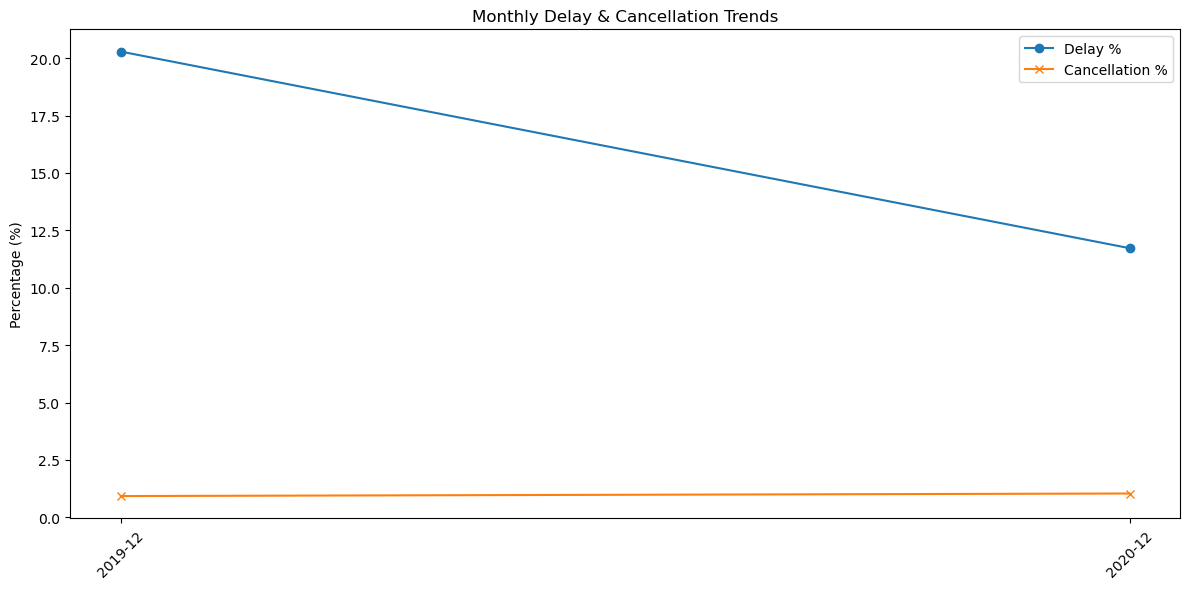

In [36]:
plt.figure(figsize=(12,6))
plt.plot(monthly_trends_pd['year_month'], monthly_trends_pd['pct_delayed'], marker='o', label='Delay %')
plt.plot(monthly_trends_pd['year_month'], monthly_trends_pd['pct_cancelled'], marker='x', label='Cancellation %')
plt.xticks(monthly_trends_pd['year_month'][::max(1,len(monthly_trends_pd)//20)], rotation=45)
plt.ylabel('Percentage (%)')
plt.title('Monthly Delay & Cancellation Trends')
plt.legend()
plt.tight_layout()
plt.show()

In [37]:
# 16. Airport Reliability Rankings
airport_reliability = df.groupBy('airport','airport_name') \
    .agg(
        spark_sum('arr_flights').alias('flights'),
        spark_sum('arr_del15').alias('delayed'),
        spark_sum('arr_cancelled').alias('cancelled')
    ) \
    .withColumn('reliability_score', spark_round((1 - ((col('delayed')+col('cancelled'))/col('flights')))*100,2)) \
    .orderBy(col('reliability_score').desc())

In [38]:
airport_reliability.show(10, truncate=False)

+-------+-----------------------------------------------+-------+-------+---------+-----------------+
|airport|airport_name                                   |flights|delayed|cancelled|reliability_score|
+-------+-----------------------------------------------+-------+-------+---------+-----------------+
|PGV    |Greenville, NC: Pitt Greenville                |2.0    |0.0    |0.0      |100.0            |
|BFM    |Mobile, AL: Mobile Downtown                    |12.0   |0.0    |0.0      |100.0            |
|GUM    |Guam, TT: Guam International                   |119.0  |6.0    |0.0      |94.96            |
|CSG    |Columbus, GA: Columbus Airport                 |179.0  |10.0   |0.0      |94.41            |
|CDC    |Cedar City, UT: Cedar City Regional            |106.0  |6.0    |0.0      |94.34            |
|HTS    |Ashland, WV: Tri-State/Milton J. Ferguson Field|78.0   |5.0    |0.0      |93.59            |
|ITO    |Hilo, HI: Hilo International                   |851.0  |52.0   |4.0      

In [39]:
# 17. Correlation of Delay Causes
delay_causes_pd = df.select(cause_cols).toPandas()
corr_matrix = delay_causes_pd.corr()

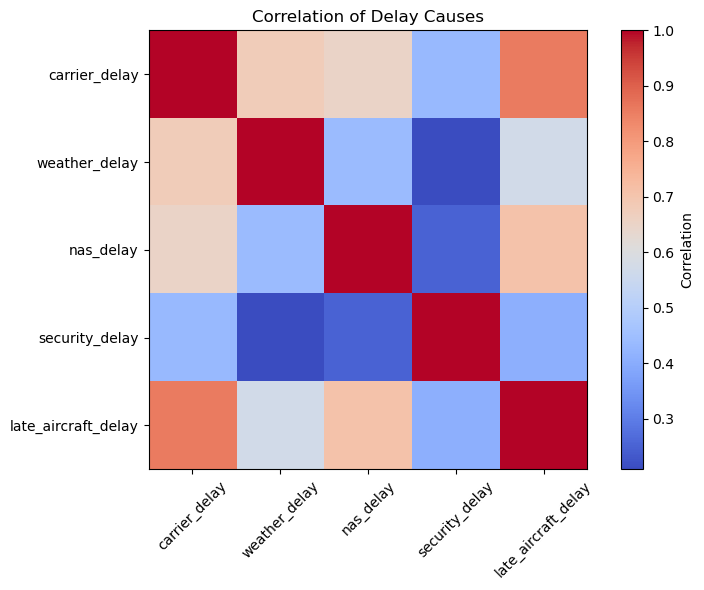

In [40]:
plt.figure(figsize=(8,6))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation')
plt.xticks(range(len(cause_cols)), cause_cols, rotation=45)
plt.yticks(range(len(cause_cols)), cause_cols)
plt.title('Correlation of Delay Causes')
plt.tight_layout()
plt.show()

In [41]:

# Step 18: Stop Spark Session

spark.stop()
print("\n✅ Analysis Completed Successfully!")


✅ Analysis Completed Successfully!
